### Imagenet Benchmark

This is to see the GPU performance on imagenet training dataset

2022-07-24 01:05:34.791254: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [1]:
import tensorflow as tf
trainable = False
import time
num_classes=500
mon_start = 20
mon_end = 40
eries_folder = 'scalingNCCL'
#run_series_folder = 'scalinggRPC'
host_count = 1
BATCH_SIZE = host_count * 8 * 32
learning_rate = 1e-5*host_count

2022-07-24 03:37:20.307604: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
mon_start = 20
mon_end = 40


#steps_per_epoch = int(np.ceil(len(train_labels)/BATCH_SIZE))
steps_per_epoch = 40
#validation_size = 1000
#validation_size = len(val_labels)
validation_steps = 1
validation_size = 100

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-07-24 03:37:21.769072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-24 03:37:23.253660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37109 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
2022-07-24 03:37:23.255959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37841 MB memory:  -> devi

In [12]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


In [13]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [84]:
import cv2 

def deserialize_tfrecord(tfrec):
   
    '''
      parse the tfrecord
    '''
    feature={
      'image/height':  tf.io.FixedLenFeature([], tf.int64),
      'image/width':  tf.io.FixedLenFeature([], tf.int64),
      'image/colorspace':tf.io.FixedLenFeature([], tf.string),
      'image/channels':  tf.io.FixedLenFeature([], tf.int64),
      'image/class/label': tf.io.FixedLenFeature([], tf.int64),
      'image/class/synset': tf.io.FixedLenFeature([], tf.string),
      'image/format': tf.io.FixedLenFeature([], tf.string),
      'image/filename': tf.io.FixedLenFeature([], tf.string),
      'image/encoded': tf.io.FixedLenFeature([], tf.string)}
        
    file_rec = tf.io.parse_single_example(tfrec, feature)
    img_enc = file_rec["image/encoded"]
    image = tf.io.decode_jpeg(img_enc)
    print ("Preprocess", image.shape)
    
    image = tf.image.resize_with_crop_or_pad(image, 256,256)
    image_shape = (256, 256)
    a= tf.slice(tf.shape(image),begin=[2], size=[1])
    #image = tf.image.resize_with_pad(image, *image_shape)
    #image = tf.zeros([256,256,3], tf.uint8)
    def fn1():
      return  image
    def fn2():
        return tf.image.grayscale_to_rgb(image)

    image = tf.cond(tf.equal(a,tf.constant(3)),  fn1, fn2)
    '''
    if (image.shape[-1] < 3):
        img=image
        img2 = np.zeros( ( np.array(img).shape[0], np.array(img).shape[1], 3 ) )
        img2[:,:,0] = img # same value in each channel
        img2[:,:,1] = img
        img2[:,:,2] = img
        image=img2'''
    print ("Post process",image.shape)
    #image = cv2.resize(image, (50, 50), 
     #                      interpolation=cv2.INTER_NEAREST)

    print(image.shape)
    label = file_rec["image/class/label"]
    # need to one hot when using TFRecord, because when reading from SSD the labels are one hot separately
    num_classes=500
    #print (label)
    label = tf.one_hot(label,depth=num_classes )
    #print(label)
    return image, label

In [85]:
BATCH_SIZE=400

In [86]:
def get_training_dataset(infected_path):
    tf.print("In training dataset")
    train_prefetch_dataset = create_prefetch_dataset(infected_path)
    tf.print("Done building training dataset")
    return train_prefetch_dataset

def get_validation_dataset(infected_path):
    tf.print("In validation dataset")
    validation_prefetch_dataset = create_prefetch_dataset(infected_path)
    tf.print("Done building validation dataset")
    return validation_prefetch_dataset

def create_prefetch_dataset(fname):
    print('Creating Prefetch Dataset From', fname)
    # list_files have shuffle True by default
    dataset = tf.data.Dataset.list_files(fname)
    # Maxes out CPU
    dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(deserialize_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat(-1)
    return dataset



In [87]:
from tensorflow.keras import layers
def make_model(input_shape, num_classes):
    tf.print("Model Inpute shape", input_shape)
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    #x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [88]:
import tensorflow as tf
import tensorflow.keras as keras
image_size = (256,256)

#keras.utils.plot_model(model, show_shapes=True)

In [89]:
model = None
BATCH_SIZE=256
train_data_path="gs://cloud-ml-nas-public/classification/imagenet/train*" #"gs://nas-public-dataset/imagenet/tf_records/train/*"

    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
model = make_model(input_shape=image_size +(3,), num_classes=500)
model.compile(optimizer=keras.optimizers.Adam(1e-3),loss="categorical_crossentropy", metrics=["accuracy"],steps_per_execution=10)
print(model)
model.fit(get_training_dataset(train_data_path),steps_per_epoch = 8, epochs=10)

Model Inpute shape (256, 256, 3)
In training dataset
Creating Prefetch Dataset From gs://cloud-ml-nas-public/classification/imagenet/train*
Preprocess (None, None, None)
Post process (256, 256, None)
(256, 256, None)
Done building training dataset
Epoch 1/10
8/8 [==============================] - 30s 4s/step - loss: 3.1638 - accuracy: 0.0015
Epoch 2/10
8/8 [==============================] - 2s 243ms/step - loss: 3.2488 - accuracy: 0.0034
Epoch 3/10
8/8 [==============================] - 8s 1s/step - loss: 3.3958 - accuracy: 0.0024
Epoch 4/10
8/8 [==============================] - 2s 245ms/step - loss: 3.2527 - accuracy: 0.0015
Epoch 5/10
8/8 [==============================] - 3s 334ms/step - loss: 3.0659 - accuracy: 0.0015
Epoch 6/10
8/8 [==============================] - 2s 241ms/step - loss: 3.1633 - accuracy: 9.7656e-04
Epoch 7/10
8/8 [==============================] - 2s 240ms/step - loss: 3.1194 - accuracy: 9.7656e-04
Epoch 8/10
8/8 [==============================] - 4s 509ms/step

In [ ]:
model = None
train_data_path="gs://cloud-ml-nas-public/classification/imagenet/train*"
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))
BATCH_SIZE=1100
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model = make_model(input_shape=image_size +(3,), num_classes=500)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),loss="categorical_crossentropy", metrics=["accuracy"],steps_per_execution=10)
    print(model)
model.fit(get_training_dataset(train_data_path),steps_per_epoch = 10, epochs=10)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Model Inpute shape (256, 256, 3)
In training dataset
Creating Prefetch Dataset From gs://cloud-ml-nas-public/classification/imagenet/train*
Preprocess (None, None, None)
Post process (256, 256, None)
(256, 256, None)
Done building training dataset
Epoch 1/10
10/10 [==============================] - 37s 4s/step - loss: 3.1642 - accuracy: 0.0018
Epoch 2/10
10/10 [==============================] - 9s 880ms/step - loss: 3.1261 - accuracy: 0.0031
Epoch 3/10
10/10 [==============================] - 10s 950ms/step - loss: 3.1548 - accuracy: 0.0025
Epoch 4/10
10/10 [==============================] - 10s 1000ms/step - loss: 3.1753 - accuracy: 0.0012
Epoch 5/10
10/10 [==============================] - 15s 2s/step - loss: 3.1714 - accuracy: 0.0014
Epoch 6/10
10/10 [==============================] - 10s 959ms/step - loss: 3.1503 -

In [132]:
model

In [21]:
import tensorflow as tf 
raw_dataset = tf.data.TFRecordDataset("gs://nas-public-dataset/imagenet/tf_records/train/train-00595-of-01024")
result = {}
labels = []
for raw_record in raw_dataset:
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    image, label = deserialize_tfrecord(raw_record)
    val = image.shape[-1]
    image = tf.image.random_crop(image, (50,50,val))
    #print (image.numpy().shape)
    #print (type(image))
    labels.append(label)
    for key, feature in example.features.feature.items():
    # The values are the Feature objects which contain a `kind` which contains:
    # one of three fields: bytes_list, float_list, int64_list

     kind = feature.WhichOneof('kind')
     #print(key, kind)
     result[key] = (getattr(feature, kind).value)
    #print(file_rec)
len(result["image/class/label"])

Preprocess (500, 375, 3)
Post process (256, 256, 3)
(256, 256, 3)
Preprocess (375, 500, 3)
Post process (256, 256, 3)
(256, 256, 3)
Preprocess (375, 500, 3)
Post process (256, 256, 3)
(256, 256, 3)
Preprocess (296, 500, 3)
Post process (256, 256, 3)
(256, 256, 3)
Preprocess (417, 500, 3)
Post process (256, 256, 3)
(256, 256, 3)
Preprocess (375, 500, 3)
Post process (256, 256, 3)
(256, 256, 3)
Preprocess (500, 359, 3)
Post process (256, 256, 3)
(256, 256, 3)
Preprocess (500, 333, 3)
Post process (256, 256, 3)
(256, 256, 3)
Preprocess (333, 500, 3)
Post process (256, 256, 3)
(256, 256, 3)
Preprocess (386, 354, 3)
Post process (256, 256, 3)
(256, 256, 3)
Preprocess (500, 372, 3)
Post process (256, 256, 3)
(256, 256, 3)
Preprocess (375, 500, 3)
Post process (256, 256, 3)
(256, 256, 3)
Preprocess (331, 500, 3)
Post process (256, 256, 3)
(256, 256, 3)
Preprocess (400, 400, 3)
Post process (256, 256, 3)
(256, 256, 3)
Preprocess (375, 500, 3)
Post process (256, 256, 3)
(256, 256, 3)
Preprocess

1

In [96]:
import numpy as np
len(np.unique(labels))

695

In [51]:
count = 0
for raw_record in raw_dataset:
  count= count+1
print(count)

1159


In [42]:
img_enc = result["image/encoded"][0]
img_arr = tf.io.decode_jpeg(img_enc).numpy()

In [44]:
import matplotlib.pyplot as plt

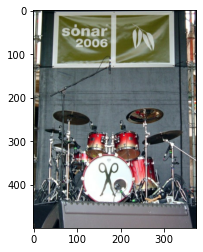

In [45]:
plt.imshow(img_arr)

In [47]:
result["image/filename"]

[b'n03249569_12274.JPEG']